## 课时71 TF2.0版本WGAN实现

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE
%matplotlib inline
tf.__version__

'2.4.0'

### 1. 读取数据以及数据预处理

In [4]:
images_path = "../training_data/apple2orange 2"
os.listdir(images_path)

['.DS_Store', 'testA', 'trainB', 'testB', 'trainA']

In [5]:
# 获取各自文件夹下对应的所有图片
train_images_A_path = glob.glob(images_path + '/trainA/*.jpg')
train_images_B_path = glob.glob(images_path + '/trainB/*.jpg')
test_images_A_path = glob.glob(images_path + '/testA/*.jpg')
test_images_B_path = glob.glob(images_path + '/testB/*.jpg')

In [6]:
def read_jpg_images(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    return input_image

def load_jpg_image(image_path):
    img = read_jpg_images(image_path)
    img = tf.image.resize(img, (256, 256)) # 这一步可做可不做
    img = normalize(img)
    return img

In [7]:
# 创建dataset
train_A_dataset = tf.data.Dataset.from_tensor_slices(train_images_A_path)
train_B_dataset = tf.data.Dataset.from_tensor_slices(train_images_B_path)
test_A_dataset = tf.data.Dataset.from_tensor_slices(test_images_A_path)
test_B_dataset = tf.data.Dataset.from_tensor_slices(test_images_B_path)

In [8]:
BUFFER_SIZE = 200
BATCH_SIZE = 1
train_A_dataset = train_A_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B_dataset = train_B_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A_dataset = test_A_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B_dataset = test_B_dataset.map(load_jpg_image, 
        num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

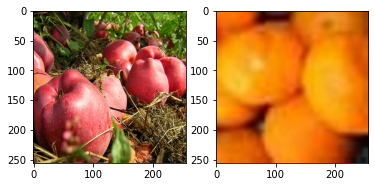

In [9]:
train_dataset = tf.data.Dataset.zip((train_A_dataset, train_B_dataset))
test_dataset = tf.data.Dataset.zip((test_A_dataset, test_B_dataset))

# 显示一下图片
for apple_image, orange_image in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(apple_image[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(orange_image[0]))

### 2. 实例标准化(Instance Normalization)
>Instance Normalization作用于单张图片，而Batch Normalization作用于一个batch的图片，实例标准化非常适合用于style transfer任务中

In [43]:
!pip install -i https://pypi.douban.com/simple tensorflow_addons

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 515 kB 1.0 MB/s 


In [10]:
import tensorflow_addons as tfa

### 3. 创建生成器和判别器

In [11]:
# 定义上采样和下采样，方便堆叠U-Net结构
def downsample(filters, kernel_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                               strides=2, padding='same'),
        tfa.layers.InstanceNormalization(),
        tf.keras.layers.LeakyReLU()])
    return model

In [12]:
def upsample(filters, kernel_size, rate=0):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, 
                                        strides=2, padding='same'),
        # 实例标准化
        tfa.layers.InstanceNormalization(),
        # 默认的rate=0代表不使用dropout
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.LeakyReLU()])
    return model

In [13]:
# 定义生成器
def Generator_model():
    # 使用函数式API进行模型定义
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    down_stack = [downsample(filters=64,  kernel_size=4),  # [128, 128, 64]
                  downsample(filters=128, kernel_size=4),  # [64, 64, 128]
                  downsample(filters=256, kernel_size=4),  # [32, 32, 256]
                  downsample(filters=512, kernel_size=4),  # [16, 16, 512]
                  downsample(filters=512, kernel_size=4),  # [8, 8, 512]
                  downsample(filters=512, kernel_size=4),  # [4, 4, 512]
                  downsample(filters=512, kernel_size=4),  # [2, 2, 512]
                  downsample(filters=512, kernel_size=4)]  # [1, 1, 512]
    
    up_stack = [upsample(filters=512, kernel_size=4, rate=0.5), # [2, 2, 512]
                upsample(filters=512, kernel_size=4, rate=0.5), # [4, 4, 512]
                upsample(filters=512, kernel_size=4, rate=0.5), # [8, 8, 512]
                upsample(filters=512, kernel_size=4),           # [16, 16, 512]
                upsample(filters=256, kernel_size=4),           # [32, 32, 256]
                upsample(filters=128, kernel_size=4),           # [64, 64, 128]
                upsample(filters=64,  kernel_size=4)]           # [128, 128, 64]
    # 将concat之后的结果进行输出 [256, 256, 3]
    upsample_last_result = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=4,                                                            strides=2, padding='same',                                                           activation='tanh')
    
    x = inputs
    # 用来存放下采样的每一层的中间结果，便于后续与上采样对应层进行concat
    downsample_skip_layers_result = []
    # 循环调用下采样列表中定义的各个下采样层
    for down in down_stack:
        x = down(x)
        # 对于每个下采样层的中间输出结果，由于后续需要与上采样层对应层进行concat操作
        # 因此需要使用一个列表将每个中间结果保留下来
        downsample_skip_layers_result.append(x)
    # 从定义的G来看，由于最后一层的输出结果大小为1，并不参与到与上采样层中某一层的concat
    # 因此在保留中间结果的skip列表中将其删除
    # 此外，由于上下采样层concat是上下翻转的，因此为了方便concat，将skip列表进行翻转
    downsample_skip_layers_result = reversed(downsample_skip_layers_result[:-1])
    
    # 执行下采样，并与skip结果就进行concat
    for up, skip_result in zip(up_stack, downsample_skip_layers_result):
        x = up(x)
        # 需要注意的是：它与tf.concat([A, B], axis=-1)效果一样，Concatenate默认axis=-1
        x = tf.keras.layers.Concatenate()([x, skip_result])
    # 将上采样concat结果进过最后一层进行输出
    x = upsample_last_result(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
def Discriminator_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    down1 = downsample(filters=64, kernel_size=4)(inputs) # [128, 128, 64]
    down2 = downsample(filters=128, kernel_size=4)(down1) # [64, 64, 128]
    down3 = downsample(filters=256, kernel_size=4)(down2) # [32, 32, 256]
    # 接下来采用patch_GAN的方式进行处理，也即对图像一个部分一个部分的进行处理
    # patch_GAN中图像的大小为[30, 30]，因此这里先进行填充，然后再进行卷积
    zero_pad_1 = tf.keras.layers.ZeroPadding2D()(down3) # [34, 34, 256]
    # [31, 31, 512]
    conv = tf.keras.layers.Conv2D(filters=512, kernel_size=4, strides=1)(zero_pad_1)
    norm = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm)
    # [33, 33, 512]
    zero_pad_2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    # [30, 30, 1]
    last = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1)(zero_pad_2)
    return tf.keras.Model(inputs=inputs, outputs=last)

### 4. 损失函数

In [24]:
Binary_Crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real_image_outputs, fake_image_outputs):
    real_image_loss = Binary_Crossentropy(y_true=tf.ones_like(real_image_outputs),                                            y_pred=real_image_outputs)
    fake_image_loss = Binary_Crossentropy(y_true=tf.zeros_like(fake_image_outputs),                                           y_pred=fake_image_outputs)
    d_total_loss = real_image_loss + fake_image_loss
    return d_total_loss

In [31]:
def generator_loss(fake_image_outputs):
    fake_image_loss = Binary_Crossentropy(y_true=tf.ones_like(fake_image_outputs),                                            y_pred=fake_image_outputs)
    return fake_image_loss

In [40]:
# 控制循环一致损失的超参数，可以进行调节的，让损失中循环损失的比重增大
Lambda = 7
def cycle_loss(real_image_outputs, cycled_image_output):
    loss = tf.reduce_mean(tf.abs(real_image_outputs - cycled_image_output))
    return loss * Lambda

In [33]:
generator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 5. 定义辅助绘图函数

In [34]:
def plot_generated_images(model, test_input):
    generated_images = model(inputs=test_input, training=True)
    fig = plt.figure(figsize=(15, 15))
    display_list = [test_input[0], generated_images[0]]
    title = ["Input image", "Generated image"]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

### 6. 定义梯度更新函数

In [35]:
generator_X = Generator_model()
generator_Y = Generator_model()
discriminator_X = Discriminator_model()
discriminator_Y = Discriminator_model()

In [39]:
@tf.function
def train_step(image_A, image_B):
    """
    generator_x: apple --> orange
    generator_y: orange --> apple
    discriminator_x: apple
    discriminator_x: orange
    """
    with tf.GradientTape(persistent=True) as tape:
        # 前向计算部分
        # ==========================================================
        # 输入的图片A经过G_X将图片转换到B领域
        generated_image_B = generator_X(inputs=image_A, training=True)
        # 转换到B领域的图片给了G_Y之后又给转换到了A领域
        cycled_image_A = generator_Y(inputs=generated_image_B, training=True)

        generated_image_A = generator_Y(inputs=image_B, training=True)
        cycled_image_B = generator_X(inputs=generated_image_A, training=True)

        real_image_A_out = discriminator_X(inputs=image_A, training=True)
        real_image_B_out = discriminator_Y(inputs=image_B, training=True)

        fake_image_A_out = discriminator_X(inputs=generated_image_A, training=True)
        fake_image_B_out = discriminator_Y(inputs=generated_image_B, training=True)
        # ===========================================================
        # 损失计算部分
        # ===========================================================
        discriminator_X_loss = discriminator_loss(real_image_A_out, fake_image_A_out)
        discriminator_Y_loss = discriminator_loss(real_image_B_out, fake_image_B_out)

        generator_X_loss = generator_loss(generated_image_B)
        generator_Y_loss = generator_loss(generated_image_A)
        total_cycle_loss = cycle_loss(image_A, cycled_image_A)+cycle_loss(image_B, cycled_image_B)

        total_generator_X_loss = generator_X_loss + total_cycle_loss
        total_generator_Y_loss = generator_Y_loss + total_cycle_loss

    # =========================================================
    generator_X_gradients = tape.gradient(total_generator_X_loss,
                                          generator_X.trainable_variables)
    generator_Y_gradients = tape.gradient(total_generator_Y_loss,
                                          generator_Y.trainable_variables)
    discriminator_X_gradients = tape.gradient(discriminator_X_loss,
                                              discriminator_X.trainable_variables)
    discriminator_Y_gradients = tape.gradient(discriminator_Y_loss,
                                              discriminator_Y.trainable_variables)

    # ============================================================
    generator_X_optimizer.apply_gradients(zip(generator_X_gradients,                                                               generator_X.trainable_variables))
    generator_Y_optimizer.apply_gradients(zip(generator_Y_gradients,                                                               generator_Y.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients,                                                   discriminator_X.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients,                                                   discriminator_Y.trainable_variables))

### 7. 定义模型训练函数

In [ ]:
def train(train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        for images_a, images_b in train_dataset:
            train_step(images_a, images_b)
            print('.', end=' ')
        print()
        if epoch % 5 == 0:
            for test_a, test_b in test_dataset.take(1):
                print('now epoch is:', epoch)
                plot_generated_images(generator_X, test_a)
                print()
                plot_generated_images(generator_Y, test_b)

In [ ]:
train(train_dataset, test_dataset, 150)